In [25]:
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load(r"../word2vec-google-news-300.model")
print(len(word2vec_model))
# print(word2vec_model.key_to_index["a"])

3000000


In [26]:

import numpy as np
import json
# this code is taken from online and slightly modified

with open(r"../vocab.json") as f:
    dict = json.load(f)
    word_set = set(dict.keys())
vocab = set(word2vec_model.key_to_index.keys())

def charMapping(word_set):
    final_word_set = set()
    charMap = {}
    for word in vocab:
        if word in word_set:
            charMap[word] = word
            final_word_set.add(word)
        elif word.lower() in word_set:
            charMap[word.lower()] = word
            final_word_set.add(word.lower())
    word_set = final_word_set
    return charMap

def augment_wordset_with_OOV(word_set):
    with open(r"../oovMap.json") as f:
        dict = json.load(f)
        # print(dict)
        for key in dict:
            words = dict[key]
            for word in words:
                word_set.add(word)
            if key in word_set:
                word_set.remove(key)

def restrict_w2v(w2v, restricted_word_set, handle_oov=False):
    # Handle OOV words if specified
    if handle_oov:
        augment_wordset_with_OOV(restricted_word_set)
        charMap = charMapping(restricted_word_set)
    
    # Sort restricted_word_set for deterministic processing
    sorted_word_set = sorted(restricted_word_set)

    new_key_to_index = {}  # Map word to index
    new_index_to_key = {}  # Map index to word
    new_vectors = []

    # Add padding token with zero vector
    new_key_to_index["</s>"] = 0
    new_index_to_key[0] = "</s>"
    new_vectors.append([0] * 300)  # Assuming 300 dimensions for vectors

    # Sort charMap keys for deterministic indexing
    for word in sorted_word_set:
        # Check if the word is in charMap to include it
        if word not in charMap:
            continue
        
        # Retrieve the word index from the original model
        original_word = charMap[word]
        index = w2v.key_to_index[original_word]
        vec = w2v.vectors[index]
        
        # Assign a new index for each word and add to new data structures
        val = len(new_key_to_index)
        new_key_to_index[word] = val
        new_index_to_key[val] = word
        new_vectors.append(vec)

    # Update model's attributes with the deterministic restricted set
    w2v.key_to_index = new_key_to_index
    w2v.index_to_key = new_index_to_key
    w2v.vectors = np.array(new_vectors)

restrict_w2v(word2vec_model, word_set, handle_oov=True)
print(len(word2vec_model.vectors))
# print(word2vec_model.key_to_index["a"])
print(word2vec_model.key_to_index.get("compassionately"))
print("Vocabulary size:", len(word2vec_model.key_to_index))

15583
2601
Vocabulary size: 15583


In [27]:
import sys
import torch.nn.utils.rnn as rnn_utils
import torch.nn as nn
import torch
from gensim.models import KeyedVectors

class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.2, activationfn='tanh', bidirectional=True):
        super(SentimentLSTM, self).__init__()
        
        # Embedding layer with batch normalization
        self.embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.vectors), freeze=False, padding_idx=0)
        self.embed_norm = nn.BatchNorm1d(input_size)
        self.activation = nn.ReLU()
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=num_layers,
            bias=True,
            batch_first=True, 
            dropout=dropout, 
            bidirectional=bidirectional
        )

        # Fully connected layer with batch normalization
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.lstm_norm = nn.BatchNorm1d(lstm_output_size)
        self.fc = nn.Linear(lstm_output_size, output_size)

    def forward(self, x, mask):
        # Embedding layer with batch normalization
        x = self.embed_layer(x)
        
        # Transpose for BatchNorm1d, which expects (batch, features, sequence_length)
        # x = x.transpose(1, 2)
        # x = self.embed_norm(x)
        # x = x.transpose(1, 2)
        
        x = self.activation(x)
        
        # Calculate mask for packed sequence
        mask = (x.sum(dim=2) != 0).float()
        lengths = mask.sum(dim=1).int()
        
        # Pack the padded sequence for the LSTM
        packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        packed_out, hidden = self.lstm(packed_x)
        
        # Unpack the sequence
        out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
        
        # Apply mean pooling over valid parts only
        out = (out * mask.unsqueeze(2)).sum(dim=1) / mask.sum(dim=1, keepdim=True)
        
        # Apply batch normalization to the LSTM output
        # out = self.lstm_norm(out)
        
        # Fully connected layer
        out = self.fc(out)
        
        return out


In [28]:
with open(r"../oovMap.json") as f:
    oovMap = json.load(f)

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class SentimentDataset(Dataset):
    def __init__(self, dataset, word2vec_model, max_length=100):
        self.dataset = dataset
        self.word2vec = word2vec_model
        self.max_length = max_length  # Maximum sequence length for padding

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get text and label
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        
        # Convert text to embeddings
        tokens = text # Assuming text is tokenized already
        # embeddings = [self.word2vec[word] for word in tokens if word in self.word2vec]
        # embeddings = [self.word2vec.key_to_index.get(word) for word in tokens if word in self.word2vec]
        embeddings = []
        # print(tokens)
        for word in tokens:
            # print("word: ", word)
            if word in self.word2vec:
                embeddings.append(self.word2vec.key_to_index.get(word))
                continue
            if word not in oovMap:
                continue
            for chunk in oovMap[word]:
                # print("chunk:" , chunk)
                embeddings.append(self.word2vec.key_to_index.get(chunk))            
        
        # Truncate sequences - will pad later
        if len(embeddings) > self.max_length:
            embeddings = embeddings[:self.max_length]
        
        if len(embeddings) == 0:
            return self.__getitem__((idx + 1) % len(self.dataset))  # Skip empty sequences
        
        embeddings = np.array(embeddings)
        
        return torch.tensor(embeddings, dtype=torch.int32), torch.tensor(label, dtype=torch.float32)

def collate_fn(batch):
    '''Creates mini-batch tensors from the list of tuples (embeddings, labels, mask).'''
    
    # embedding_dim = batch[0][0].size(1)
    
    # Separate embeddings and labels
    embeddings = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # print(len(batch))     
    # print(embeddings)
    # Stack them into tensors
    embeddings = pad_sequence(embeddings, batch_first=True) # (B, L, D)
    # print(len(batch))     
    # print([len(embeddings[i]) for i in range(len(embeddings))])
    # Create the mask
    mask = (embeddings != 0).float() # (B, L) - 1 if there is a word, 0 if it's a padding
    
    labels = torch.stack(labels)
    
    return embeddings, labels, mask


In [30]:
from datasets import load_from_disk
import gensim.downloader as api
from gensim.models import KeyedVectors

# This is the training dataset
path_to_train_set = r"../tokenised_datasets/tokenised_train_dataset"
train_dataset = load_from_disk(path_to_train_set)
train_data = SentimentDataset(train_dataset, word2vec_model)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Get the same for test and validation
path_to_test_set = r"../tokenised_datasets/tokenised_test_dataset"
test_dataset = load_from_disk(path_to_test_set)
test_data = SentimentDataset(test_dataset, word2vec_model)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

path_to_val_set = r"../tokenised_datasets/tokenised_validation_dataset"
val_dataset = load_from_disk(path_to_val_set)
val_data = SentimentDataset(val_dataset, word2vec_model)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [31]:
# Define model parameters
input_size = word2vec_model.vector_size         # Dimension of Word2Vec embeddings
hidden_size = 64        # Number of hidden units
output_size = 1          # Output size (1 for binary classification)
num_layers = 3           # Number of stacked RNN layers
dropout = 0.6        # Dropout rate for regularization


In [32]:
def validate_model(model, val_loader, device, criterion, val_losses=[], val_accuracies=[]):
    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():  # Disable gradient tracking for validation
        for val_embeddings, val_labels, mask in val_loader:
            val_embeddings, val_labels, mask = val_embeddings.to(device), val_labels.to(device), mask.to(device)
            val_outputs = model(val_embeddings, mask).squeeze()
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_labels.size(0)  # Multiply by batch size for total loss
            val_predictions = (torch.sigmoid(val_outputs) >= 0.5).float()  # Threshold at 0.5
            val_correct_predictions += (val_predictions == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / val_total_samples
    val_accuracy = val_correct_predictions / val_total_samples
    
    # Store validation metrics for plotting
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    

Epoch 1/100, Loss: 0.6932, Accuracy: 0.5008 Validation Accuracy: 0.5310
Epoch 2/100, Loss: 0.6923, Accuracy: 0.5403 Validation Accuracy: 0.6201
Epoch 3/100, Loss: 0.6491, Accuracy: 0.6597 Validation Accuracy: 0.6820
Epoch 4/100, Loss: 0.5477, Accuracy: 0.7399 Validation Accuracy: 0.6998
Epoch 5/100, Loss: 0.4879, Accuracy: 0.7797 Validation Accuracy: 0.7195
Epoch 6/100, Loss: 0.4419, Accuracy: 0.8111 Validation Accuracy: 0.7364
Epoch 7/100, Loss: 0.4020, Accuracy: 0.8299 Validation Accuracy: 0.7186
Epoch 8/100, Loss: 0.3683, Accuracy: 0.8484 Validation Accuracy: 0.7439
Epoch 9/100, Loss: 0.3302, Accuracy: 0.8659 Validation Accuracy: 0.7439
Epoch 10/100, Loss: 0.3012, Accuracy: 0.8862 Validation Accuracy: 0.7467
Epoch 11/100, Loss: 0.2724, Accuracy: 0.8972 Validation Accuracy: 0.7486
Epoch 12/100, Loss: 0.2436, Accuracy: 0.9127 Validation Accuracy: 0.7505
Early stopping


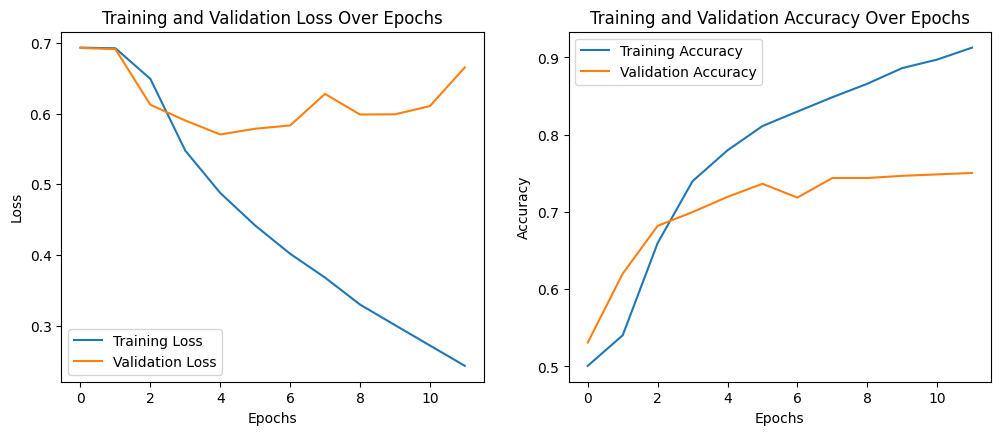

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim

# Binary Cross-Entropy Loss with Logits
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with the model's parameters and a learning rate
learning_rate = 5e-5

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = SentimentLSTM(input_size, hidden_size, output_size, num_layers, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)


# Training parameters
num_epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Set the model to training mode
    model.train()
    for embeddings, labels, mask in train_loader:
        # Move data to the same device as model (GPU if available)
        embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(embeddings, mask).squeeze()

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print the gradients
        # for name, param in model.named_parameters():
        #     print(name, param.grad)
        
        # Accumulate the loss and accuracy
        epoch_loss += loss.item() * labels.size(0)  # Multiply by batch size for total loss
        predictions = (torch.sigmoid(outputs) >= 0.5).float()  # Threshold at 0.5
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # Store metrics for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}", end=" ")
    validate_model(
        model,
        val_loader,
        device,
        criterion,
        val_losses,
        val_accuracies
    )
    # Early stopping: if the moving average validation accuracy has decreased, then stop
    if epoch > 10 and val_losses[-1] > np.mean(val_losses[-10:-1]):
        print("Early stopping")
        break 

# Plot the training and validation loss and accuracy over epochs
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()

# Epoch 61/100, Loss: 0.3699, Accuracy: 0.8591 Validation Accuracy: 0.7317

In [ ]:
# Plot the training and validation loss and accuracy over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


In [ ]:
# import torch
# # Save the model
torch.save(model.state_dict(), 'sentiment_bilstm_2hl_{}_{}_with_OOV.pth'.format(hidden_size, str(learning_rate)[2:]))

# load the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SentimentLSTM(input_size, hidden_size, output_size, num_layers, dropout).to(device)
# model.load_state_dict(torch.load('sentiment_bilstm_2hl_64_-05_with_OOV.pth'))

In [ ]:
from datasets import load_from_disk
from gensim.models import KeyedVectors


# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print('reach')
# This is the word2vec model
# word2vec_model = KeyedVectors.load(r"../word2vec-google-news-300.model")

# Set the model to evaluation mode
model.eval()

test_predictions = []
test_targets = []

# print(len(test_loader))
for i, x in enumerate(test_loader):
    # print(i, end = " ")
    embeddings, labels, mask = x
    # Move data to the same device as model
    embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
    
    # Forward pass
    outputs = model(embeddings, mask).squeeze()
    
    # Store the actual and predicted labels
    predictions = (torch.sigmoid(outputs) >= 0.5).float()
    test_predictions.extend(predictions.tolist())
    test_targets.extend(labels.tolist())
    
# Calculate the test accuracy
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)
test_accuracy = np.mean(test_predictions == test_targets)

print(f"testing accuracy: {test_accuracy:.4f}")

testing accuracy: 0.7720


## Hyper-parameter tuning

In [13]:
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import itertools

# Set device for GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the parameter grid
param_grid = {
    'hidden_size': [16, 32, 64],
    'num_layers': [2, 3],
    'dropout': [0.4, 0.6],
    'bidirectional': [True],
    'learning_rate': [5e-5, 1e-5, 5e-6],
    'num_epochs': [60],
    'optimizer': ['Adam', 'AdamW']  # Add optimizer types here
}

# Store the best validation accuracy and corresponding parameters
best_val_accuracy = 0
best_params = None

# Iterate through all combinations of parameters
for hidden_size, num_layers, dropout, bidirectional, learning_rate, num_epochs, optimizer_name in itertools.product(
        param_grid['hidden_size'],
        param_grid['num_layers'],
        param_grid['dropout'],
        param_grid['bidirectional'],
        param_grid['learning_rate'],
        param_grid['num_epochs'],
        param_grid['optimizer']):

    # Initialize the model with current parameters
    model = SentimentLSTM(input_size, hidden_size, output_size, num_layers, dropout, bidirectional).to(device)
    
    # Choose optimizer based on the parameter
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5, weight_decay=1e-6)
    if optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SparseAdam':
        optimizer = optim.SparseAdam(model.parameters(), lr=learning_rate)
    if optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    
    # Criterion
    criterion = nn.BCEWithLogitsLoss()
    
    # Initialize lists for tracking training and validation performance
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # Training loop for current parameter combination
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        model.train()
        
        # Training step
        for embeddings, labels, mask in train_loader:
            embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings, mask).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * labels.size(0)
            predictions = (torch.sigmoid(outputs) >= 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)
        
        # Calculate and store average loss and accuracy for this epoch
        avg_loss = epoch_loss / total_samples
        accuracy = correct_predictions / total_samples
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        
        # Validation step
        model.eval()
        val_epoch_loss, val_correct_predictions, val_total_samples = 0.0, 0, 0
        with torch.no_grad():
            for val_embeddings, val_labels, val_mask in val_loader:
                val_embeddings, val_labels, val_mask = val_embeddings.to(device), val_labels.to(device), val_mask.to(device)
                val_outputs = model(val_embeddings, val_mask).squeeze()
                val_loss = criterion(val_outputs, val_labels)
                val_epoch_loss += val_loss.item() * val_labels.size(0)
                val_predictions = (torch.sigmoid(val_outputs) >= 0.5).float()
                val_correct_predictions += (val_predictions == val_labels).sum().item()
                val_total_samples += val_labels.size(0)
        
        val_avg_loss = val_epoch_loss / val_total_samples
        val_accuracy = val_correct_predictions / val_total_samples
        val_losses.append(val_avg_loss)
        val_accuracies.append(val_accuracy)
        
        # Early stopping based on validation accuracy
        if epoch > 10 and val_accuracies[-1] < np.mean(val_accuracies[-10:-1]):
            print("Early stopping triggered")
            break
    
    # Print metrics for current configuration
    print(f"Params: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, "
          f"bidirectional={bidirectional}, learning_rate={learning_rate}, num_epochs={num_epochs}, optimizer={optimizer_name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Update best parameters if current validation accuracy is the highest
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'dropout': dropout,
            'bidirectional': bidirectional,
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name
        }

# Final results
print("Best Validation Accuracy:", best_val_accuracy)
print("Best Parameters:", best_params)


Early stopping triggered
Params: hidden_size=16, num_layers=2, dropout=0.4, bidirectional=True, learning_rate=5e-05, num_epochs=60, optimizer=Adam
Validation Accuracy: 0.7336
Early stopping triggered
Params: hidden_size=16, num_layers=2, dropout=0.4, bidirectional=True, learning_rate=5e-05, num_epochs=60, optimizer=AdamW
Validation Accuracy: 0.7148
Early stopping triggered
Params: hidden_size=16, num_layers=2, dropout=0.4, bidirectional=True, learning_rate=1e-05, num_epochs=60, optimizer=Adam
Validation Accuracy: 0.7008
Early stopping triggered
Params: hidden_size=16, num_layers=2, dropout=0.4, bidirectional=True, learning_rate=1e-05, num_epochs=60, optimizer=AdamW
Validation Accuracy: 0.7289
Early stopping triggered
Params: hidden_size=16, num_layers=2, dropout=0.4, bidirectional=True, learning_rate=5e-06, num_epochs=60, optimizer=Adam
Validation Accuracy: 0.6623
Early stopping triggered
Params: hidden_size=16, num_layers=2, dropout=0.4, bidirectional=True, learning_rate=5e-06, num_ep

In [83]:
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import itertools
from datasets import load_from_disk
import gensim.downloader as api
from gensim.models import KeyedVectors


# Set device for GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size =[128, 64, 32, 16]
# Define the parameter grid
param_grid = {
    'hidden_size': [32, 64],
    'num_layers': [2, 3],
    'dropout': [0.6, 0.7],
    'bidirectional': [True],
    'learning_rate': [1e-4, 5e-5],
    'num_epochs': [100],
    'optimizer': ['Adam']  # Add optimizer types here
}

# Store the best validation accuracy and corresponding parameters
best_val_accuracy = 0
best_params = None

for batchSize in batch_size:
    
    # This is the training dataset
    path_to_train_set = r"../tokenised_datasets/tokenised_train_dataset"
    train_dataset = load_from_disk(path_to_train_set)
    train_data = SentimentDataset(train_dataset, word2vec_model)
    train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True, collate_fn=collate_fn)
    
    # Get the same for test and validation
    path_to_test_set = r"../tokenised_datasets/tokenised_test_dataset"
    test_dataset = load_from_disk(path_to_test_set)
    test_data = SentimentDataset(test_dataset, word2vec_model)
    test_loader = DataLoader(test_data, batch_size=batchSize, shuffle=False, collate_fn=collate_fn)
    
    path_to_val_set = r"../tokenised_datasets/tokenised_validation_dataset"
    val_dataset = load_from_disk(path_to_val_set)
    val_data = SentimentDataset(val_dataset, word2vec_model)
    val_loader = DataLoader(val_data, batch_size=batchSize, shuffle=False, collate_fn=collate_fn)
    # Iterate through all combinations of parameters
    for hidden_size, num_layers, dropout, bidirectional, learning_rate, num_epochs, optimizer_name in itertools.product(
            param_grid['hidden_size'],
            param_grid['num_layers'],
            param_grid['dropout'],
            param_grid['bidirectional'],
            param_grid['learning_rate'],
            param_grid['num_epochs'],
            param_grid['optimizer']):
    
        # Initialize the model with current parameters
        model = SentimentLSTM(input_size, hidden_size, output_size, num_layers, dropout, bidirectional).to(device)
        
        # Choose optimizer based on the parameter
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
        elif optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-6)
        elif optimizer_name == 'Adagrad':
            optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-6)
    
        # Criterion
        criterion = nn.BCEWithLogitsLoss()
        
        # Initialize lists for tracking training and validation performance
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        
        # Training loop for current parameter combination
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            correct_predictions = 0
            total_samples = 0
            model.train()
            
            # Training step
            for embeddings, labels, mask in train_loader:
                embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
                optimizer.zero_grad()
                outputs = model(embeddings, mask).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item() * labels.size(0)
                predictions = (torch.sigmoid(outputs) >= 0.5).float()
                correct_predictions += (predictions == labels).sum().item()
                total_samples += labels.size(0)
            
            # Calculate and store average loss and accuracy for this epoch
            avg_loss = epoch_loss / total_samples
            accuracy = correct_predictions / total_samples
            train_losses.append(avg_loss)
            train_accuracies.append(accuracy)
            
            # Validation step
            model.eval()
            val_epoch_loss, val_correct_predictions, val_total_samples = 0.0, 0, 0
            with torch.no_grad():
                for val_embeddings, val_labels, val_mask in val_loader:
                    val_embeddings, val_labels, val_mask = val_embeddings.to(device), val_labels.to(device), val_mask.to(device)
                    val_outputs = model(val_embeddings, val_mask).squeeze()
                    val_loss = criterion(val_outputs, val_labels)
                    val_epoch_loss += val_loss.item() * val_labels.size(0)
                    val_predictions = (torch.sigmoid(val_outputs) >= 0.5).float()
                    val_correct_predictions += (val_predictions == val_labels).sum().item()
                    val_total_samples += val_labels.size(0)
            
            val_avg_loss = val_epoch_loss / val_total_samples
            val_accuracy = val_correct_predictions / val_total_samples
            val_losses.append(val_avg_loss)
            val_accuracies.append(val_accuracy)
            
            # Early stopping based on validation accuracy
            if epoch > 10 and val_losses[-1] > np.mean(val_losses[-10:-1]):
                print("Early stopping triggered")
                break
        
        # Print metrics for current configuration
        print(f"Params: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, batchsize={batchSize}, "
              f"bidirectional={bidirectional}, learning_rate={learning_rate}, num_epochs={num_epochs}, optimizer={optimizer_name}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        # Update best parameters if current validation accuracy is the highest
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout': dropout,
                'bidirectional': bidirectional,
                'learning_rate': learning_rate,
                'num_epochs': num_epochs,
                'optimizer': optimizer_name,
                'batch_size': batchSize
            }

# Final results
print("Best Validation Accuracy:", best_val_accuracy)
print("Best Parameters:", best_params)


Early stopping triggered
Params: hidden_size=32, num_layers=2, dropout=0.6, batchsize=128, bidirectional=True, learning_rate=0.0001, num_epochs=100, optimizer=Adam
Validation Accuracy: 0.7402
Early stopping triggered
Params: hidden_size=32, num_layers=2, dropout=0.6, batchsize=128, bidirectional=True, learning_rate=5e-05, num_epochs=100, optimizer=Adam
Validation Accuracy: 0.7373
Early stopping triggered
Params: hidden_size=32, num_layers=2, dropout=0.7, batchsize=128, bidirectional=True, learning_rate=0.0001, num_epochs=100, optimizer=Adam
Validation Accuracy: 0.7373
Early stopping triggered
Params: hidden_size=32, num_layers=2, dropout=0.7, batchsize=128, bidirectional=True, learning_rate=5e-05, num_epochs=100, optimizer=Adam
Validation Accuracy: 0.7383
Early stopping triggered
Params: hidden_size=32, num_layers=3, dropout=0.6, batchsize=128, bidirectional=True, learning_rate=0.0001, num_epochs=100, optimizer=Adam
Validation Accuracy: 0.7533
Early stopping triggered
Params: hidden_si